In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.stats import norm

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

#### 1. Smith-Wilson Extrapolation

In [2]:
# Smith-Wilson Class 정의

class SmithWilson:
    
    def __init__(self, alpha, UFR, term, rate):
        self.alpha = alpha
        self.UFR = UFR
        self.term = term
        self.rate = rate
        self.zeta = self.__calcZeta()
        return None
        
    def Wilson(self,t,u,order=0):
        alpha = self.alpha
        UFR = self.UFR
        if order == 0:
            wilson = np.exp(-UFR*(t+u))*(alpha*np.fmin(t,u) - np.exp(-alpha*np.fmax(t,u))*np.sinh(alpha*np.fmin(t,u)))
        elif order == 1:
            if t < u: wilson = np.exp(-UFR*t-(alpha+UFR)*u)*(UFR*np.sinh(alpha*t)-alpha*np.cosh(alpha*t)-alpha*(UFR*t-1)*np.exp(alpha*u))
            else: wilson = np.exp(-UFR*u-(alpha+UFR)*t)*((alpha+UFR)*np.sinh(alpha*u)-alpha*UFR*u*np.exp(alpha*t))
        elif order == 2:
            if t < u: wilson = np.exp(-UFR*t-(alpha+UFR)*u)*(-(alpha**2+UFR**2)*np.sinh(alpha*t)+2*alpha*UFR*np.cosh(alpha*t)+alpha*UFR*(UFR*t-2)*np.exp(alpha*u)) 
            else: wilson = np.exp(-UFR*u-(alpha+UFR)*t)*(alpha*UFR**2*u*np.exp(alpha*t)-(alpha+UFR)**2*np.sinh(alpha*u))
        else:
            print('유효한 Order가 아닙니다.')
        return wilson
    
    def __calcZeta(self):
        n = len(self.term)
        W = np.zeros([n,n])
        for i in range(n):
            for j in range(n):
                W[i,j] = self.Wilson(self.term[i],self.term[j])
        m = 1/(1+self.rate)**self.term
        mu = np.exp(-self.UFR*self.term)
        zeta = np.matmul(m-mu,np.linalg.inv(W))
        return zeta
        
    def Bond(self, t, order=0):
        bond = (-self.UFR)**order*np.exp(-self.UFR*t) + np.matmul(self.zeta, [self.Wilson(t, s, order) for s in sw.term])
        return bond
                                                                
    def YieldCurve(self, t):
        # t = 0 일 때 에러가 나는 것을 방지하기 위해 임의의 최소값 1e-6를 넣음
        t = np.fmax(t,1e-6)
        curve = 1/self.Bond(t)**(1/t) - 1
        return curve
    
    def Forward(self,t,order=0):
        if order == 0: forward = -self.Bond(t,1)/self.Bond(t,0)
        elif order == 1: forward = 1/self.Bond(t,0)*(-self.Bond(t,1)**2/self.Bond(t,0) + self.Bond(t,2))
        else: print('유효한 Order가 아닙니다.')
        return forward
    
    def __calcError(self, alpha, tol, M):
        sw = SmithWilson(alpha, self.UFR, self.term, self.rate)
        y = abs(tol-abs(sw.Forward(M)-self.UFR))
        return y
    
    def calcAlpha(self, tol=1e-4, M=60):
        # 수정 필요
        res = minimize_scalar(self.__calcError, method='bounded', bounds=(1e-3,1) ,args=(tol, M), options={'disp':False})
        return res.x
    
    def setAlpha(self, alpha):
        self.alpha = alpha
        self.zeta = self.__calcZeta()
        return None
    
    def fSwapRate(self, T, S, tau=0.25):
        fsr = (self.Bond(T)-self.Bond(S))/(tau*sum(list(map(lambda x:self.Bond(x),np.arange(T,S,tau)+tau))))
        return fsr
    
    def rsBlackATM(self, sigma, T, S):
        d1 = 0.5*sigma*np.sqrt(T)
        rs = (self.Bond(T)-self.Bond(S))*(2*norm.cdf(d1)-1)
        return rs

In [3]:
# 초기화

alpha = 0.05
UFR = 0.045
rate = np.array([0.0334,0.0326,0.0327,0.0328,0.033,0.0335,0.0342,0.0345,0.0347,0.0352])
term = np.array([1,2,3,4,5,7,10,12,15,20])

sw = SmithWilson(alpha, UFR, term, rate)
sw.setAlpha(sw.calcAlpha())

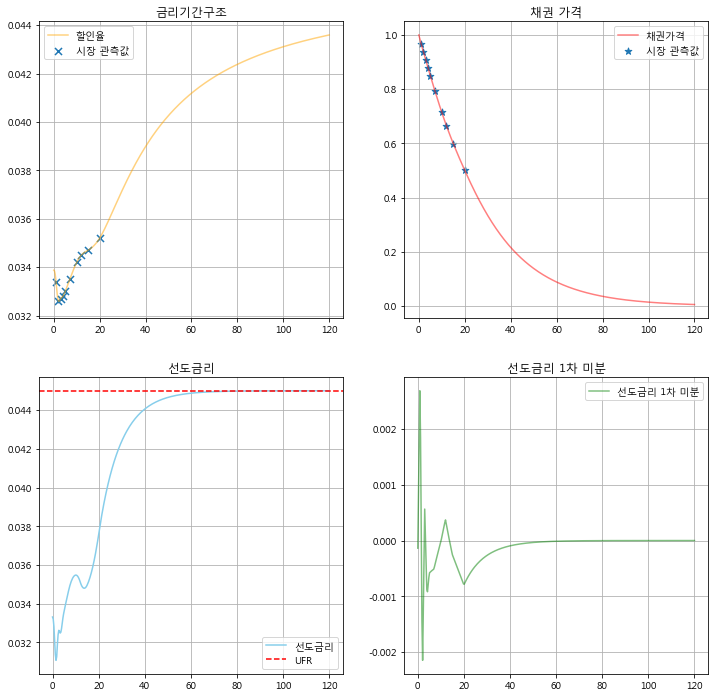

In [4]:
# 그래프 그리기

plt.figure(figsize=(12,12))

x = np.linspace(0,120,400)

plt.subplot(221)
y = np.array(list(map(lambda x:sw.YieldCurve(x), x)))
plt.plot(x,y, c='orange', alpha=0.5)
plt.scatter(sw.term,sw.rate, marker='x', s=50)
plt.legend(['할인율','시장 관측값'])
plt.title('금리기간구조')
plt.grid(True)

plt.subplot(222)
y = np.array(list(map(lambda x:sw.Bond(x, order=0), x)))
plt.plot(x,y, c='red', alpha=0.5)
plt.scatter(sw.term,1/(1+sw.rate)**sw.term, marker='*', s=50)
plt.legend(['채권가격','시장 관측값'])
plt.title('채권 가격')
plt.grid(True)

plt.subplot(223)
y = np.array(list(map(lambda x:sw.Forward(x), x)))
plt.plot(x,y, c='skyblue')
plt.axhline(y=sw.UFR, c='red', linestyle='dashed')
plt.legend(['선도금리', 'UFR'])
plt.title('선도금리')
plt.grid(True)

plt.subplot(224)
y = np.array(list(map(lambda x:sw.Forward(x, order=1), x)))
plt.plot(x,y, c='green', alpha=0.5)
plt.title('선도금리 1차 미분')
plt.legend(['선도금리 1차 미분'])
plt.grid(True)

plt.show()

#### 2. Hull-White Model

In [5]:
# Hull-White Class 정의

class HullWhite:
    
    def __init__(self, curve, alpha, sigma):
        self.curve = curve
        self.alpha = alpha
        self.sigma = sigma
    
    def Sigma(self,T,S):
        alpha = self.alpha
        sigma = self.sigma
        sigma_p = (np.exp(-alpha*T)-np.exp(-alpha*S))*(sigma/alpha)*np.sqrt((np.exp(2*alpha*T)-1)/(2*alpha))
        return sigma_p
    
    def __fSwapCashFlow(self,T,S,tau=0.25):
        cf = self.curve.fSwapRate(T,S,tau)*np.ones(int((S-T)/tau))*tau
        cf[-1] += 1
        return cf
    
    def Jamshidian(self,T,S,tau=0.25):
        c = self.__fSwapCashFlow(T,S,tau)
        obj = lambda r: abs(np.sum(c*np.array(list(map(lambda x: self.Bond(T,x,r), np.arange(T,S,tau)+tau))))-1)
        res = minimize_scalar(obj, method='bounded', bounds=(1e-10,1), options={'xtol':1e-9,'disp':False})
        return res.x
        
    def A(self,t,T):
        alpha = self.alpha 
        sigma = self.sigma
        a = self.curve.Bond(T)/self.curve.Bond(t)*np.exp(self.B(t,T)*self.curve.Forward(t)-sigma**2*((np.exp(-alpha*T)-np.exp(-alpha*t))**2*(np.exp(2*alpha*t)-1))/(4*alpha**3))
        return a
    
    def B(self,t,T):
        b = (1-np.exp(-self.alpha*(T-t)))/self.alpha
        return b
    
    def Bond(self,t,T,r):
        bond = self.A(t,T)*np.exp(-self.B(t,T)*r)
        return bond
    
    def rsHullWhiteATM(self, T, S, tau=0.25):
        c = self.__fSwapCashFlow(T,S,tau)
        r = self.Jamshidian(T,S,tau)
        d_pos = lambda x: 1/self.Sigma(T,x)*np.log(self.Bond(0,x,r)/self.Bond(0,T,r)/self.Bond(T,x,r)) + self.Sigma(T,x)/2
        d_neg = lambda x: d_pos(x) - self.Sigma(T,x)
        f = lambda x: self.Bond(0,x,r)*norm.cdf(d_pos(x))-self.Bond(T,x,r)*self.Bond(0,T,r)*norm.cdf(d_neg(x))
        rs = sum(c*list(map(f, np.arange(T,S,tau)+tau)))
        return rs
    
    def fSwapCashFlow(self,T,S,tau=0.25):
        cf = self.curve.fSwapRate(T,S,tau)*np.ones(int((S-T)/tau))*tau
        cf[-1] += 1
        return cf

In [6]:
alpha = 0.05
sigma = 0.006

hw = HullWhite(sw, alpha, sigma)

#### 3. Calibration

In [7]:
# Loss Function 정의

alpha = 0.05
UFR = 0.045
rate = np.array([0.0334,0.0326,0.0327,0.0328,0.033,0.0335,0.0342,0.0345,0.0347,0.0352])
term = np.array([1,2,3,4,5,7,10,12,15,20])

sw = SmithWilson(alpha, UFR, term, rate)
sw.setAlpha(sw.calcAlpha())
hw = HullWhite(sw, 0.05, 0.006)

tenor = np.array([1,2,3,5,7,10])
blackVol = np.array([[0.1815,0.172,0.17,0.1605,0.158,0.155],
                     [0.177,0.1715,0.17,0.158,0.1545,0.15],
                     [0.174,0.168,0.1655,0.1555,0.1495,0.1475],
                     [0.165,0.1575,0.157,0.1495,0.1455,0.144],
                     [0.165,0.1575,0.157,0.1535,0.1455,0.144],
                     [0.1665,0.159,0.1575,0.15,0.1455,0.14]])


def Loss(x, Type=2):
    hw = HullWhite(sw, x[0], x[1])
    n = len(tenor)
    rsPriceHW = np.ones([n,n])
    rsPriceBlk = np.ones([n,n])
    if Type==1:
        for i in range(n):
            for j in range(n):
                rsPriceHW[i][j] = hw.rsHullWhiteATM(tenor[i],tenor[i]+tenor[j])
                rsPriceBlk[i][j] = sw.rsBlackATM(blackVol[i][j],tenor[i],tenor[i]+tenor[j])
    elif Type==2:
        for i in range(n):
            rsPriceHW[i][n-i-1] = hw.rsHullWhiteATM(tenor[i],tenor[i]+tenor[n-i-1])
            rsPriceBlk[i][n-i-1] = sw.rsBlackATM(blackVol[i][n-i-1],tenor[i],tenor[i]+tenor[n-i-1])
    elif Type==3:
        for i in range(n):
            rsPriceHW[i][i] = hw.rsHullWhiteATM(tenor[i],tenor[i]+tenor[i])
            rsPriceBlk[i][i] = sw.rsBlackATM(blackVol[i][i],tenor[i],tenor[i]+tenor[i])  
    else:
        print('유효한 Type이 아닙니다.')                                                            
    loss = np.sum(((rsPriceBlk-rsPriceHW)/rsPriceBlk)**2)
    return loss

In [10]:
# Calibration

x0 = np.array([0.05,0.006])
res = minimize(Loss, x0, method='nelder-mead', args=1, options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.511562
         Iterations: 30
         Function evaluations: 56


In [11]:
res.x

array([0.01097536, 0.00501672])

In [13]:
hw = HullWhite(sw , res.x[0], res.x[1])
n = len(tenor)
rsPriceHW = np.ones([n,n])
for i in range(n):
    for j in range(n):
        rsPriceHW[i][j] = hw.rsHullWhiteATM(tenor[i],tenor[i]+tenor[j])

In [15]:
rsPriceHW*100

array([[0.26586848, 0.5222292 , 0.76930596, 1.23578858, 1.66640472,
        2.24980577],
       [0.34273495, 0.6739644 , 0.99373968, 1.59926529, 2.16073595,
        2.9268378 ],
       [0.33924186, 0.66736656, 0.98439431, 1.58560241, 2.14451741,
        2.91102719],
       [0.35407528, 0.69698618, 1.02879803, 1.65992658, 2.25012471,
        3.06594939],
       [0.34891311, 0.68718634, 1.0150087 , 1.64061227, 2.22885282,
        3.04373785],
       [0.35187164, 0.6939226 , 1.02652708, 1.66435731, 2.26608954,
        3.09975877]])